Circular layout,Force-directed
"Circular layout, bundled","Force-directed, bundled"

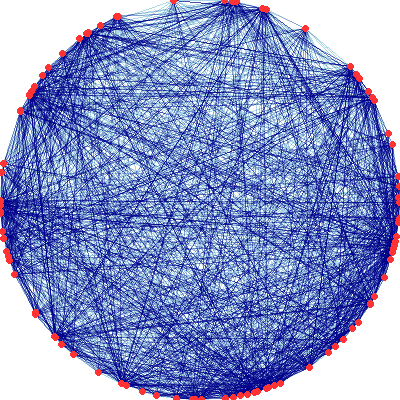
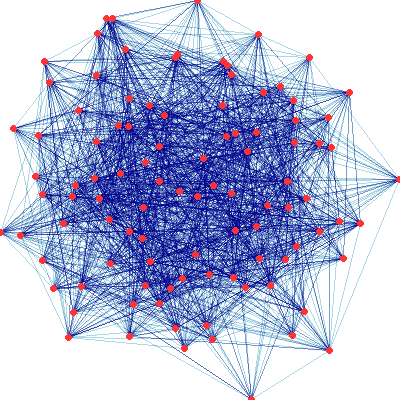
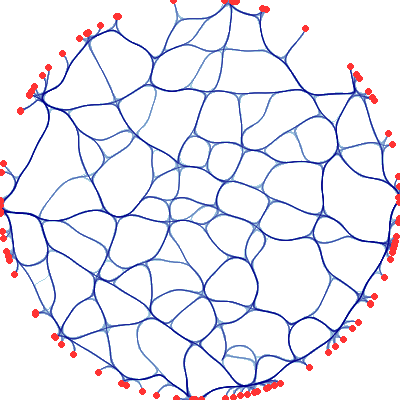
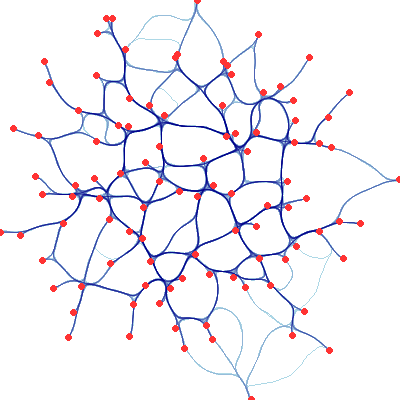

In [3]:
import math
import numpy as np
import pandas as pd

import datashader as ds
import datashader.transfer_functions as tf
from datashader.layout import random_layout, circular_layout, forceatlas2_layout
from datashader.bundling import connect_edges, hammer_bundle

from itertools import chain

np.random.seed(0)
n=100
m=2000

nodes = pd.DataFrame(["node"+str(i) for i in range(n)], columns=['name'])
nodes.tail()

edges = pd.DataFrame(np.random.randint(0,len(nodes), size=(m, 2)),
                     columns=['source', 'target'])
edges.tail()

circular  = circular_layout(nodes, uniform=False)
randomloc = random_layout(nodes)
randomloc.tail()

cvsopts = dict(plot_height=400, plot_width=400)

def nodesplot(nodes, name=None, canvas=None, cat=None):
    canvas = ds.Canvas(**cvsopts) if canvas is None else canvas
    aggregator=None if cat is None else ds.count_cat(cat)
    agg=canvas.points(nodes,'x','y',aggregator)
    return tf.spread(tf.shade(agg, cmap=["#FF3333"]), px=3, name=name)

tf.Images(nodesplot(randomloc,"Random layout"),
          nodesplot(circular, "Circular layout"))

forcedirected = forceatlas2_layout(nodes, edges)
tf.Images(nodesplot(forcedirected, "ForceAtlas2 layout"))


def edgesplot(edges, name=None, canvas=None):
    canvas = ds.Canvas(**cvsopts) if canvas is None else canvas
    return tf.shade(canvas.line(edges, 'x','y', agg=ds.count()), name=name)
    
def graphplot(nodes, edges, name="", canvas=None, cat=None):
    if canvas is None:
        xr = nodes.x.min(), nodes.x.max()
        yr = nodes.y.min(), nodes.y.max()
        canvas = ds.Canvas(x_range=xr, y_range=yr, **cvsopts)
        
    np = nodesplot(nodes, name + " nodes", canvas, cat)
    ep = edgesplot(edges, name + " edges", canvas)
    return tf.stack(ep, np, how="over", name=name)


cd = circular
fd = forcedirected

cd_d = graphplot(cd, connect_edges(cd,edges), "Circular layout")
fd_d = graphplot(fd, connect_edges(fd,edges), "Force-directed") 
cd_b = graphplot(cd, hammer_bundle(cd,edges), "Circular layout, bundled")
fd_b = graphplot(fd, hammer_bundle(fd,edges), "Force-directed, bundled") 

tf.Images(cd_d,fd_d,cd_b,fd_b).cols(2)

""

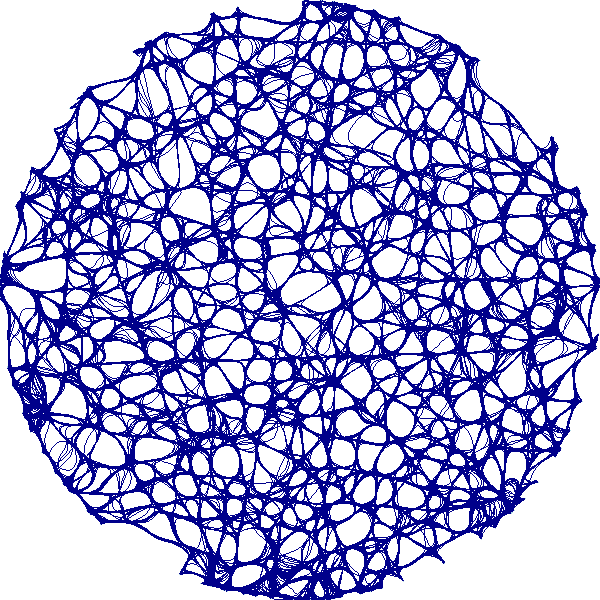

In [18]:
circular  = circular_layout(nodes, uniform=False)

xr = circular.x.min(), circular.x.max()
yr = circular.y.min(), circular.y.max()
canvas = ds.Canvas(x_range=xr, y_range=yr)

ep = tf.shade(canvas.line(hammer_bundle(circular,edges,decay=0.25), 'x','y'))
np = tf.shade(canvas.points(circular,'x','y'))
mp = tf.stack(ep, np, how="over")
tf.Images(mp)